<a href="https://colab.research.google.com/github/Pengchengzhi/Whip_in_the_middle/blob/main/synthetic_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initiate

In [1]:
!nvidia-smi

Sun Dec 12 02:12:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/542_Proj"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['data',
 'results',
 'pts.jpg',
 'angel.jpg',
 'path.jpg',
 'cifar10-train.ipynb',
 'utils',
 'interested_class_in.npy',
 'interested_class_wn.npy',
 'synthetic-train-baseline.ipynb',
 'synthetic-train.ipynb']

In [3]:
!pip install anytree

     |████████████████████████████████| 41 kB 665 kB/s 


In [4]:
import torch
import math
import matplotlib.pyplot as plt
import time
import os
import numpy as np
import csv
from torchvision import transforms
from torchvision import datasets, models
import torch.nn as nn
from torch.utils import data

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from utils.load_data import *
from utils.tree import build_tree

num_class = 56

# Hyper Parameters

In [5]:
hidden_dim = 50

# Training Parameters
nIters = 20
learning_rate = 3e-4
label_shrink = 100 

# Load Data

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])   # Nomalizaion

blur1 = transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2))
blur2 = transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2))
blur3 = transforms.GaussianBlur(kernel_size=(1, 1), sigma=(0.1, 2)) # No blur

train_transform = transforms.Compose([
          transforms.Resize([256,256]),    # Resize to 256
          transforms.RandomHorizontalFlip(),  # Random flip
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(90),    # Random rotation
          transforms.RandomPerspective(0.2),  # Random perspective change
          transforms.RandomCrop([224, 224]),  # Random Crop
          transforms.RandomChoice([blur1, blur2, blur3]),          # Random blur
          transforms.ToTensor(),
          normalize,])
val_transform = transforms.Compose([transforms.Resize([256,256]),
                  transforms.CenterCrop(224),
                  transforms.ToTensor(),
                  normalize,])

In [7]:
data_root = path+'/data/synthetic/'
        
data_train = Imgnet_Dataset(data_root, mode='train', transform=train_transform)
train_loader = data.DataLoader(data_train, batch_size=150, shuffle=False)

data_val = Imgnet_Dataset(data_root, mode='val', transform=val_transform)
val_loader = data.DataLoader(data_val, batch_size=150, shuffle=False)

Load 11647 images, used 69.236135s
Load 14486 images, used 0.397252s


# Make Label

In [8]:
label_dict = build_tree(dim_N=hidden_dim)

def label_to_vec(B, label, label_dict):
  label_vec = torch.zeros(B, hidden_dim)
  label = list(label)
  for i in range(len(label)):
    label_vec[i,:] = torch.tensor(label_dict[label[i]]).reshape(1,-1).float()
  return label_vec

# Train

In [10]:
ResNet50 = models.resnet50(pretrained=False)
fc_inputs = ResNet50.fc.in_features
ResNet50.fc = nn.Sequential(
    nn.Linear(fc_inputs,256),
    nn.ReLU(),
    nn.Linear(256,hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim))

In [11]:
def train_epoch(epoch, data_loader, model, optimizer):
  time_start = time.time()
  for i, (data, label) in enumerate(data_loader):
    B = data.shape[0]
    label_vector = label_to_vec(B, label, label_dict) #(B, hidden_dim)
    data = data.to(device)
    label_vector = label_vector.to(device)/label_shrink 

    optimizer.zero_grad()
    output = model.forward(data)
    bare_MSE = torch.sum((output-label_vector)**2, axis=1)
    loss = torch.sum(bare_MSE)/B

    loss_hist[epoch] += loss.item()
    loss.backward()
    optimizer.step()

  if (epoch+1)%1 == 0:
    time_now = time.time()
    used_minutes = (time_now - time_start)/60
    print('Round', str(epoch+1)+'/'+str(nIters),', Loss: ', round(loss_hist[epoch].item(),5), ', Using: ', round(used_minutes, 2),' mins')
    time_start = time.time()
    # for i in range(nclass):
    #   plt.scatter(label_vec[i,0].cpu().detach().numpy(), label_vec[i,1].cpu().detach().numpy())
    # #plt.xlim(-2,2) 
    # #plt.ylim(-1,1)
    # plt.title('The broccoli-like label, ROUND '+str(epoch+1))
    # plt.show()

In [12]:
model = ResNet50.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

run_name = 'run-'+ str(time.time())
result_path = path+'/results/' + run_name + '/'
train_val_metrics_path = result_path + 'train_val_metrics/'
model_path = result_path + 'saved_model.pt'
if not os.path.exists(result_path):
    os.makedirs(result_path)
    os.mkdir(train_val_metrics_path)

loss_hist = torch.zeros(nIters).to(device)

for epoch in range(nIters):
  train_epoch(epoch, train_loader, model, optimizer)

torch.save(model.state_dict(), model_path)

Round 1/20 , Loss:  11.54659 , Using:  7.35  mins
Round 2/20 , Loss:  4.95789 , Using:  3.91  mins
Round 3/20 , Loss:  4.20175 , Using:  3.92  mins
Round 4/20 , Loss:  3.86877 , Using:  3.91  mins
Round 5/20 , Loss:  4.27505 , Using:  3.89  mins
Round 6/20 , Loss:  4.31877 , Using:  3.87  mins
Round 7/20 , Loss:  4.73871 , Using:  3.93  mins
Round 8/20 , Loss:  4.79384 , Using:  3.87  mins
Round 9/20 , Loss:  4.86878 , Using:  3.81  mins
Round 10/20 , Loss:  4.63749 , Using:  3.82  mins
Round 11/20 , Loss:  4.20866 , Using:  3.8  mins
Round 12/20 , Loss:  4.65863 , Using:  3.77  mins
Round 13/20 , Loss:  4.5157 , Using:  3.87  mins
Round 14/20 , Loss:  4.5732 , Using:  3.83  mins
Round 15/20 , Loss:  3.49299 , Using:  3.86  mins
Round 16/20 , Loss:  3.4885 , Using:  3.84  mins
Round 17/20 , Loss:  3.2363 , Using:  3.85  mins
Round 18/20 , Loss:  4.13592 , Using:  3.8  mins
Round 19/20 , Loss:  4.85423 , Using:  3.79  mins
Round 20/20 , Loss:  4.66827 , Using:  3.82  mins


Text(0.5, 1.0, 'Training Loss')

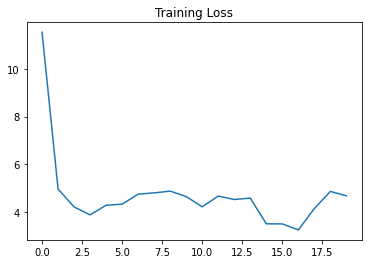

In [13]:
plt.plot(torch.arange(nIters), loss_hist.cpu().detach().numpy())
plt.title('Training Loss')

# Test

In [27]:
label_name_list = list(label_dict.keys())
label_vector_full = torch.zeros(num_class, hidden_dim).to(device)
for i in range(len(label_name_list)):
  name = label_name_list[i]
  label_vector_full[i,:] = torch.tensor(label_dict[name]).reshape(-1)

In [ ]:
data_trainset_test = Imgnet_Dataset(data_root, mode='train')
train_loader_test = data.DataLoader(data_trainset_test, batch_size=150, shuffle=False)

data_valset_test = Imgnet_Dataset(data_root, mode='val')
val_loader_test = data.DataLoader(data_valset_test, batch_size=150, shuffle=False)

In [9]:
def vector_to_prediction(output, label_vec):
  # output (B, feature_dim)
  # label_vec (num_class, feature_dim)

  diff = output.unsqueeze(1) - label_vec.cuda().unsqueeze(0) #(B, N, feature_dim)
  diff = torch.sum(diff**2,2)
  return torch.argmin(diff,dim=1) #(B,)

In [41]:
def get_label_index(y):
  l = len(y)
  label_index = torch.zeros(l).to(device)
  for i in range(l):
    label_index[i] = label_name_list.index(y[i])
  return label_index

In [47]:
# Evaluate model on test set
out_path = train_val_metrics_path + '/'

train_losses, train_preds = [], []
num_correct_train = 0
total_num_train = 0

with torch.no_grad():
  for X,y in train_loader_test:
    B = X.shape[0]
    output_vector = model(X.to(device))*label_shrink 
    label_vector = label_to_vec(B, y, label_dict).to(device)
    label_index = get_label_index(y)

    prediction = vector_to_prediction(output_vector, label_vector_full)
    loss = nn.MSELoss()(output_vector, label_vector)
    train_preds.append(prediction)
    train_losses.append(loss.item())
    num_correct_train += int(torch.sum(prediction == label_index))
    total_num_train += B

train_loss = np.mean(train_losses)
train_acc = num_correct_train/total_num_train
print('train loss: ' + str(round(train_loss,3)))
print('train accuracy: ' + str(round(train_acc*100,3))+'%')

train loss: 6.638
train accuracy: 1.563%


In [51]:
test_preds, test_losses = [], []
num_correct_test = 0
total_num_test = 0

with torch.no_grad():
  for X,y in val_loader_test:
    B = X.shape[0]
    output_vector = model(X.to(device))*label_shrink
    label_vector = label_to_vec(B, y, label_dict).to(device)
    label_index = get_label_index(y)

    prediction = vector_to_prediction(output_vector, label_vector_full)
    loss = nn.MSELoss()(output_vector, label_vector)
    test_preds.append(prediction)
    test_losses.append(loss.item())
    num_correct_test += int(torch.sum(prediction == label_index))
    total_num_test += B

test_loss = np.mean(test_losses)
test_acc = num_correct_test/total_num_test
print('test loss: ' + str(round(test_loss,3)))
print('test accuracy: ' + str(round(test_acc*100,3))+'%')

KeyboardInterrupt: ignored

In [ ]:
with open(train_val_metrics_path + 'test_model.csv', 'w') as csvfile:
  fieldnames = ['train_loss', 'train_acc', 'test_loss', 'test_acc']
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
  writer.writeheader()
  writer.writerow({'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc})